# Pre-requisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import shutil
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid

from xrd_algorithms import fit_xrd_spectrum_fast, fit_xrd_spectrum_detailed

## Heated Stage

### Import

In [2]:
import os

# Get all file names in the data directory
data_dir = "../data/XRD/heated"  # Adjust this path to your data folder
all_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')]
print(f'File names: {all_files}')

File names: ['HDPE_100C_1.csv', 'HDPE_110C_1.csv', 'HDPE_120C_1.csv', 'HDPE_29C_1.csv', 'HDPE_31C_after_1.csv', 'HDPE_50C_1.csv', 'HDPE_75C_1.csv', 'PEEK500907_100C_1.csv', 'PEEK500907_150C_1.csv', 'PEEK500907_200C_1.csv', 'PEEK500907_250C_1.csv', 'PEEK500907_26C_1.csv', 'PEEK500907_300C_1.csv', 'PEEK500907_30C_after_1.csv', 'PEEK500907_50C_1.csv']


In [3]:
df_dict = {}
for file in all_files:
    df_dict[file] = pd.read_csv(os.path.join(data_dir, file), skiprows=21)
    df_dict[file].rename(columns={'Angle': '2Theta', ' Intensity': 'Intensity'}, inplace=True)
    
    # Use data between 10° and 40° for peak detection
    df_dict[file] = df_dict[file][(df_dict[file]['2Theta'] >= 10) & (df_dict[file]['2Theta'] <= 40)]
    
    # Normalise
    df_dict[file]['Intensity_norm'] = df_dict[file]['Intensity'] / df_dict[file]['Intensity'].max()
    
    # Downsample data for faster peak detection
    # df_dict[file] = df_dict[file].iloc[::5, :]
    # df_dict[file].plot(x='2Theta', y='Intensity_norm', title=f'{file}', legend=False, linestyle='None', marker='.')
    # plt.xticks(np.arange(5, 51, 2))

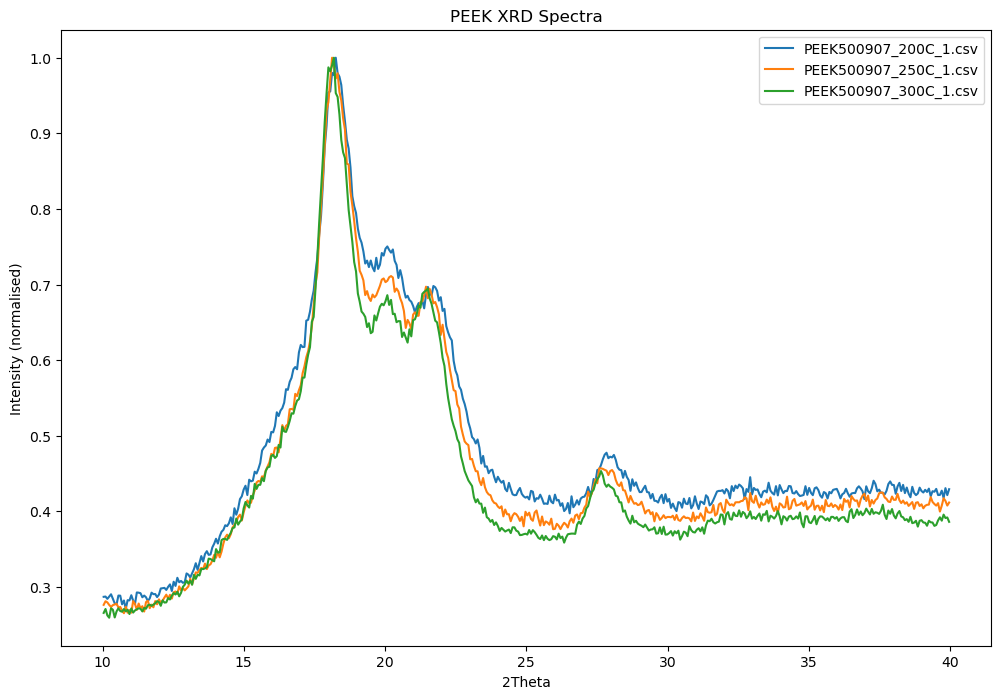

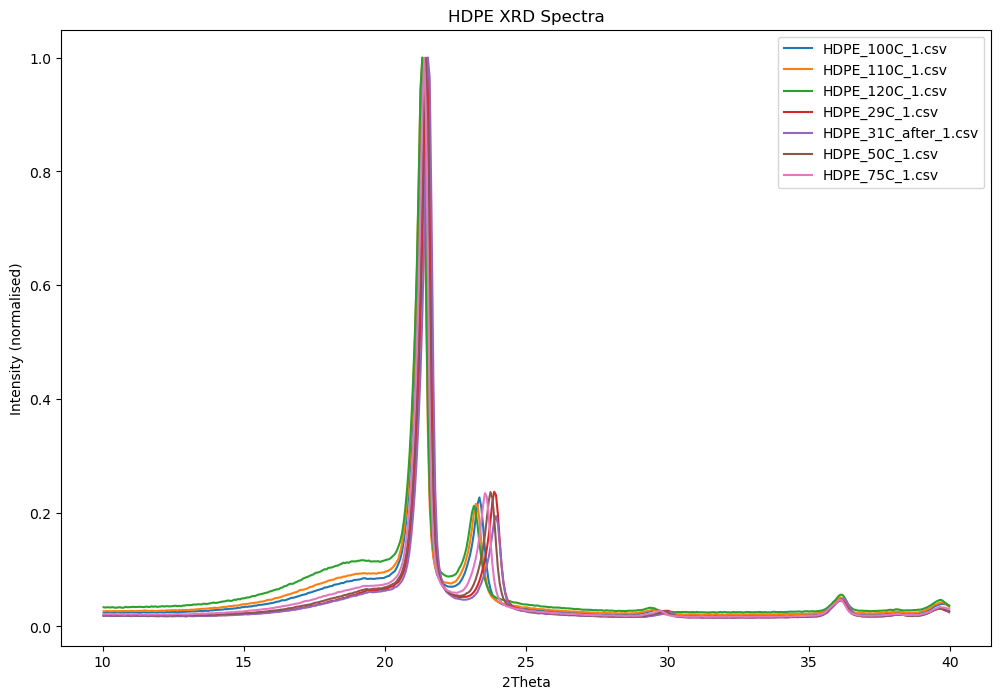

In [4]:
peek_files = [f for f in all_files if 'HDPE' not in f]
hdpe_files = [f for f in all_files if 'HDPE' in f]
subset_files = ['PEEK500907_200C_1.csv', 'PEEK500907_250C_1.csv', 'PEEK500907_300C_1.csv']

# Plot all PEEK files
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# for file in peek_files:
for file in subset_files:
    ax.plot(df_dict[file]['2Theta'], df_dict[file]['Intensity_norm'], label=file)
ax.set_xlabel('2Theta')
ax.set_ylabel('Intensity (normalised)')
ax.set_title('PEEK XRD Spectra')
ax.legend()

# Plot all HDPE files
fig2 = plt.figure(figsize=(12, 8))
ax2 = fig2.add_subplot(111)

for file in hdpe_files:
    ax2.plot(df_dict[file]['2Theta'], df_dict[file]['Intensity_norm'], label=file)
ax2.set_xlabel('2Theta')
ax2.set_ylabel('Intensity (normalised)')
ax2.set_title('HDPE XRD Spectra')
ax2.legend()

### Analysis

In [ ]:
ref_peak_dict = {
    'PEEK': [18.7, 20.6, 22.7, 28.7],   # (110), (111), (200), (211)
    'HDPE': [21.5, 23.9, 30.0, 36.2]    # (110), (200), (210), (020)
}

known_amorp_peaks_dict = {
    'PEEK': [9, 19, 22, 29, 37],
    'HDPE': [14, 17, 20, 24, 30]
}

# Provide specific crystalline peaks for each sample based on reference
sample_crys_peaks_dict = {
    # PEEK files
    'PEEK500907_26C_1.csv': [i for i in ref_peak_dict['PEEK']],     # tuned
    'PEEK500907_50C_1.csv': [i for i in ref_peak_dict['PEEK']],     # tuned
    'PEEK500907_100C_1.csv': [i for i in ref_peak_dict['PEEK']],    # tuned
    'PEEK500907_150C_1.csv': [i for i in ref_peak_dict['PEEK']],    # tuned
    'PEEK500907_200C_1.csv': [18.7+0.1, 20.6+0.1, 22.7+0.2, 28.7], # tuned
    'PEEK500907_250C_1.csv': [i for i in ref_peak_dict['PEEK']],    # tuned
    'PEEK500907_300C_1.csv': [i-0.5 for i in ref_peak_dict['PEEK']],    # tuned
    'PEEK500907_30C_after_1.csv': [i for i in ref_peak_dict['PEEK']],   # tuned
    
    # HDPE files
    'HDPE_29C_1.csv': [21.5+0.5, 23.9+0.5, 30.0+0.5, 36.2],   # half tuned
    'HDPE_50C_1.csv': [i for i in ref_peak_dict['HDPE']],   # tuned
    'HDPE_75C_1.csv': [21.5, 23.9, 30.0-0.5, 36.2],  # tuned
    'HDPE_100C_1.csv': [i-0.5 for i in ref_peak_dict['HDPE']], # half tuned
    'HDPE_110C_1.csv': [21.5-0.5, 23.9-0.7, 30.0-0.2, 36.2-0.2],    # half tuned
    'HDPE_120C_1.csv': [21.5-0.5, 23.9-0.7, 30.0-0.2, 36.2-0.2],    # half tuned
    'HDPE_31C_after_1.csv': [i for i in ref_peak_dict['HDPE']],  # tuned
}

height_width_threshold_dict = {
    'PEEK': 0.05,  # tuned
    'HDPE': 0.008,  # tuned
}

min_prominence_dict = {
    'PEEK': 0.008,  # tuned
    'HDPE': 0.0001,  # tuned
}

## Detailed fit

Processing file: HDPE_31C_after_1.csv
Low signal-to-noise ratio detected (1.66). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.2803

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.5°...
Classifying peak at 21.47° as crystalline: height/width=4.01, width=0.24° (known position)
Classifying peak at 36.14° as crystalline: height/width=0.14, width=0.28° (known position)
  Peak at 21.5°: DETECTED with good quality score (2.223) but overall R² = 0.9704 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.9°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 23.86° as crystalline: height/width=0.65, width=0.27° (known position)
Classifying peak at 36.14° as crystalline: height/width=0.13, width=0.31° (known position)
Classifying peak at 21.12° as crystalline: height/width=0.54, width=0.26° (know

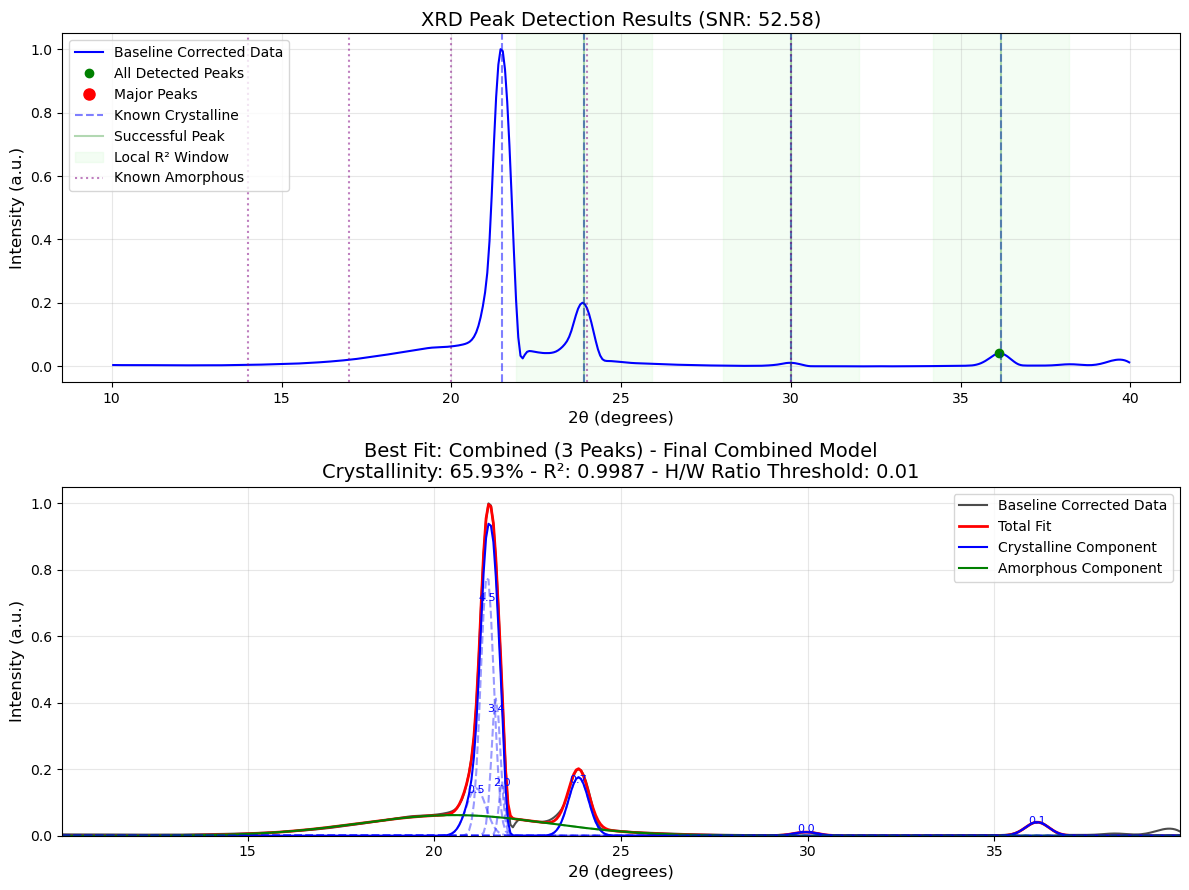

In [ ]:
# # Run one file to tune the cyrst peak position

# for file in ['HDPE_31C_after_1.csv']: #* Change this
#     print(f"Processing file: {file}")
#     if 'HDPE' in file:
#         polymer = 'HDPE'
#     else:
#         polymer = 'PEEK'
        
#     data = df_dict[file]
#     intensity = data['Intensity_norm'].values
#     two_theta = data['2Theta'].values
    
#     results = fit_xrd_spectrum_detailed(two_theta, intensity, 
#                                         min_prominence=min_prominence_dict.get(polymer, 0.05),
#                                         # min_prominence=0.00001,
#                             #    known_crys_peaks=sample_crys_peaks_dict.get(file, None),
#                                known_crys_peaks=[21.5, 23.9, 30.0, 36.2], # tune
#                                known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
#                                height_width_threshold=height_width_threshold_dict.get(polymer, 0.05),
#                             #    height_width_threshold=0.00001, # tune
#                                min_r_squared=0.99, amorphous_r_squared=0.90,
#                                visualise=True)
    

Processing file: HDPE_100C_1.csv
Low signal-to-noise ratio detected (2.01). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3425

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.0°...
Classifying peak at 21.27° as crystalline: height/width=3.94, width=0.23° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.12, width=0.27° (known position)
  Peak at 21.0°: DETECTED with good quality score (2.254) but overall R² = 0.9674 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.4°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 23.29° as crystalline: height/width=0.72, width=0.27° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.11, width=0.31° (known position)
Classifying peak at 20.91° as crystalline: height/width=0.48, width=0.27° (known pos

c:\Users\sieun\OneDrive - Imperial College London\Documents\CO2 Project\2. Experimentation\Analytical Lab\2024-08_new PEEK Characterisation\GitHub\polymer-characterisation\notebooks\xrd_algorithms.py:1218: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(multi_gaussian, two_theta, baseline_corrected_intensity,


Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 21.00° as crystalline: height/width=0.92, width=0.50° (known position)
Classifying peak at 23.40° as crystalline: height/width=0.35, width=0.50° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.05, width=0.65° (known position)
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 21.27° as crystalline: height/width=3.88, width=0.24° (known position)
Classifying peak at 23.29° as crystalline: height/width=0.71, width=0.28° (known position)
Classifying peak at 21.27° as crystalline: height/width=3.94, width=0.23° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.12, width=0.27° (known position)
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has re

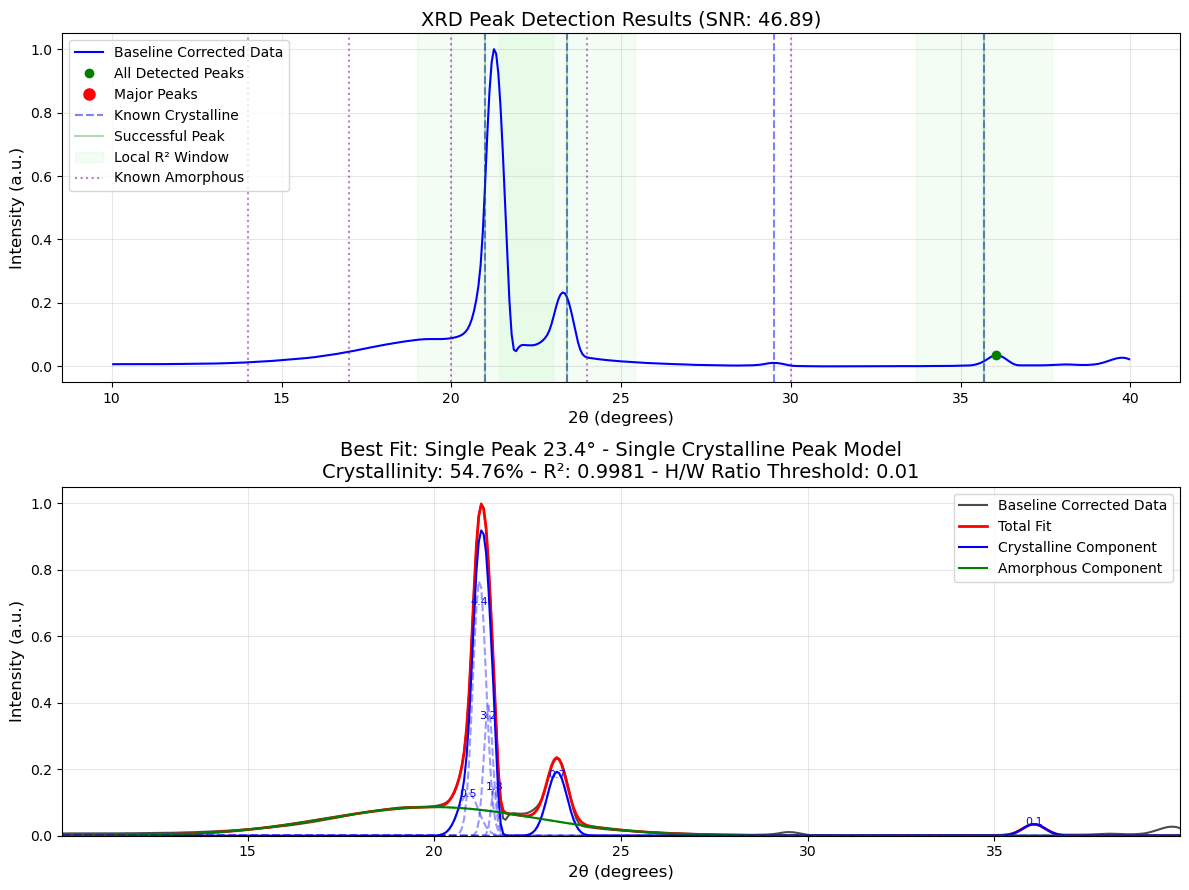

Processing file: HDPE_110C_1.csv
Low signal-to-noise ratio detected (2.12). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3610

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.0°...
Classifying peak at 21.25° as crystalline: height/width=3.91, width=0.23° (known position)
Classifying peak at 36.07° as crystalline: height/width=0.12, width=0.26° (known position)
  Peak at 21.0°: DETECTED with good quality score (2.256) but overall R² = 0.9714 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.2°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 23.20° as crystalline: height/width=0.36, width=0.50° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.05, width=0.66° (known position

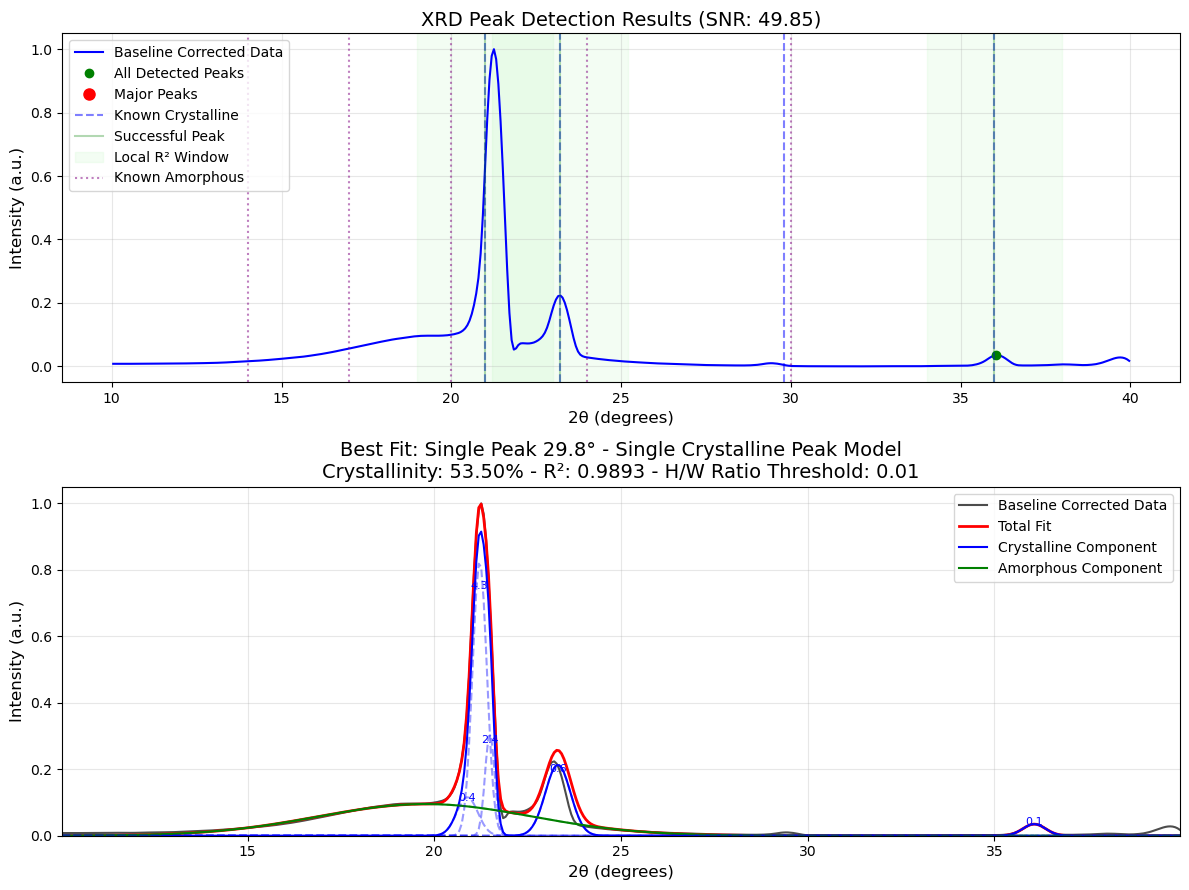

Processing file: HDPE_120C_1.csv
Low signal-to-noise ratio detected (2.42). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.4011

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.0°...
Classifying peak at 21.25° as crystalline: height/width=3.82, width=0.24° (known position)
  Peak at 21.0°: DETECTED with good quality score (2.238) but overall R² = 0.9756 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.2°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 23.20° as crystalline: height/width=0.33, width=0.50° (known position)
  Peak at 23.2°: DETECTED with good quality score (0.558) but overall R² = 0.1231 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 29.8°...
ValueError (not 

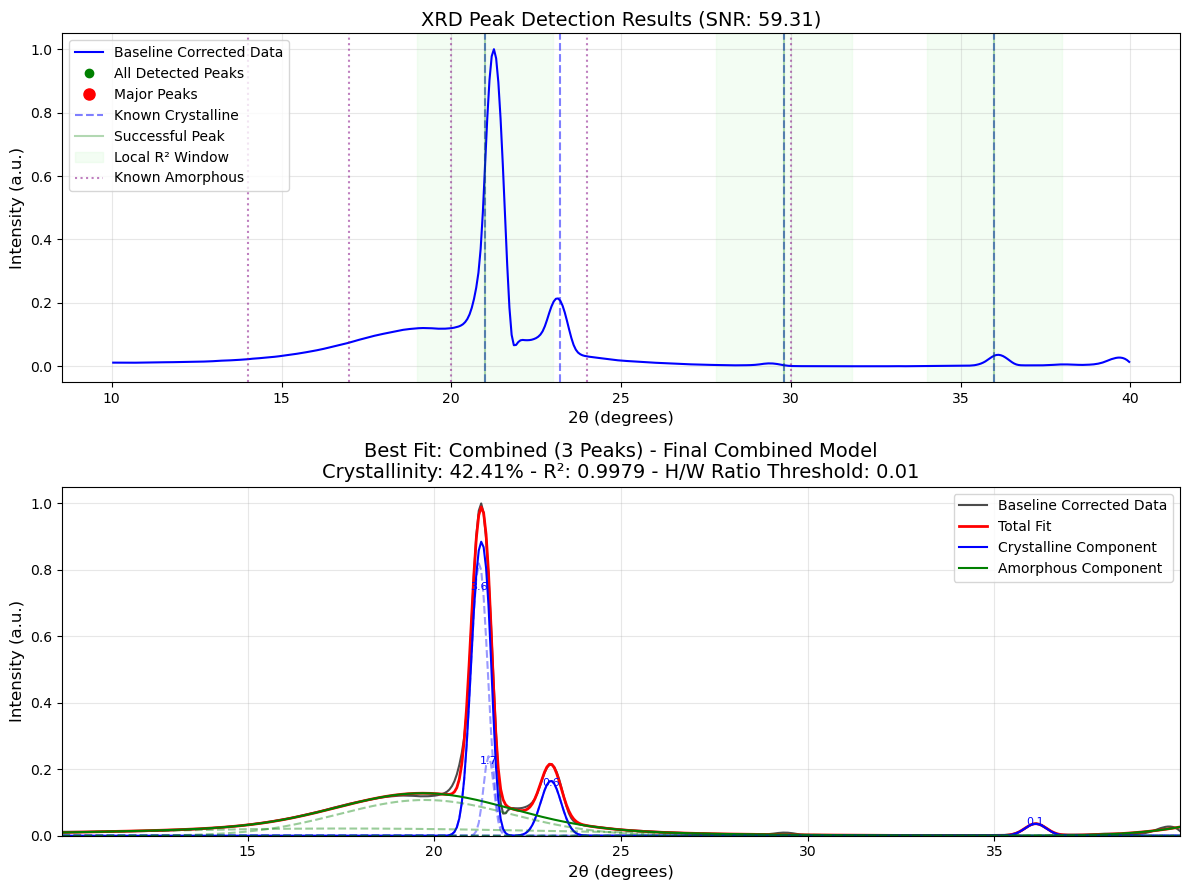

Processing file: HDPE_29C_1.csv
Low signal-to-noise ratio detected (1.74). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.2954

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 22.0°...
Classifying peak at 21.50° as crystalline: height/width=3.84, width=0.24° (known position)
Classifying peak at 36.09° as crystalline: height/width=0.12, width=0.29° (known position)
  Peak at 22.0°: DETECTED with good quality score (1.489) but overall R² = 0.9244 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 24.4°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 23.83° as crystalline: height/width=0.82, width=0.27° (known position)
Classifying peak at 36.08° as crystalline: height/width=0.12, width=0.32° (known position)
Classifying peak at 21.30° as crystalline: height/width=42.22, width=0.00° (known pos

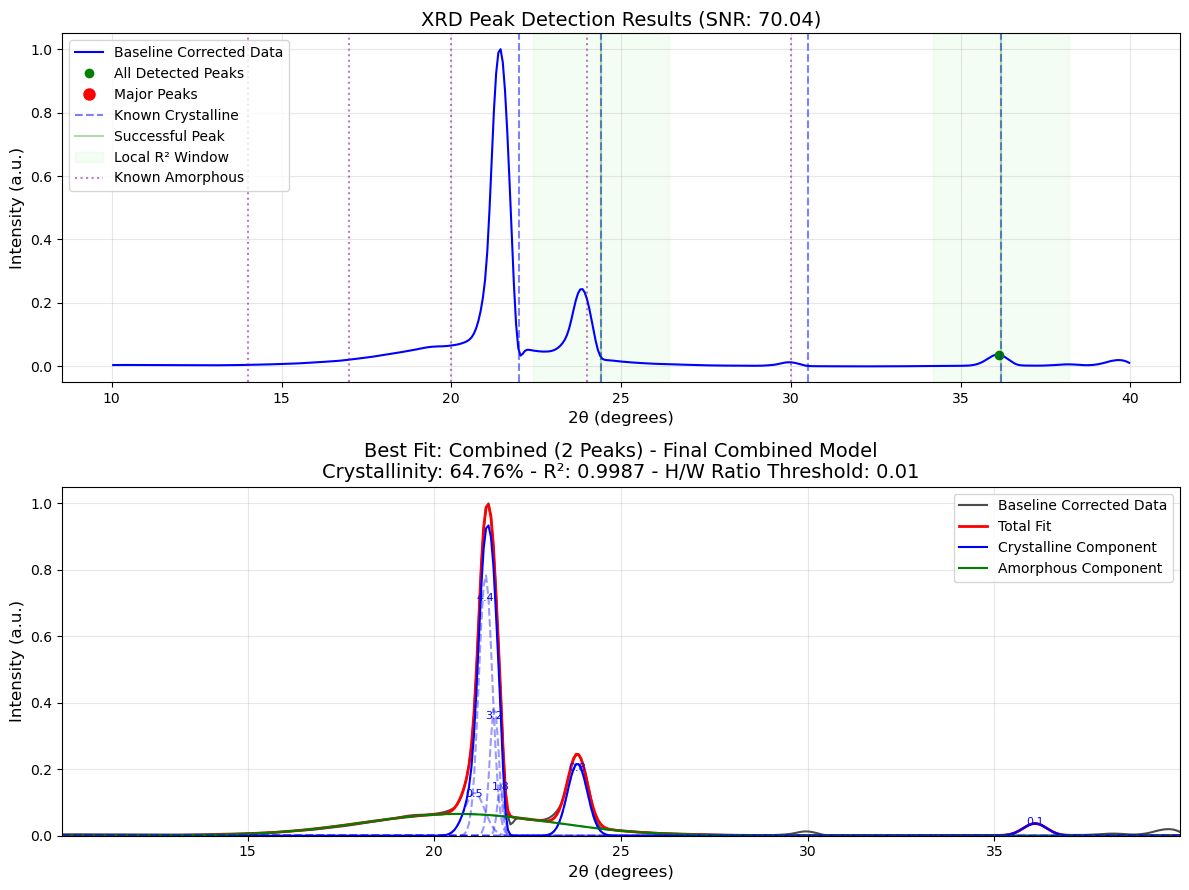

Processing file: HDPE_31C_after_1.csv
Low signal-to-noise ratio detected (1.66). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.2803

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.5°...
Classifying peak at 21.47° as crystalline: height/width=4.01, width=0.24° (known position)
Classifying peak at 36.14° as crystalline: height/width=0.14, width=0.28° (known position)
  Peak at 21.5°: DETECTED with good quality score (2.223) but overall R² = 0.9704 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.9°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 23.86° as crystalline: height/width=0.65, width=0.27° (known position)
Classifying peak at 36.14° as crystalline: height/width=0.13, width=0.31° (known position)
Classifying peak at 21.12° as crystalline: height/width=0.54, width=0.26° (know

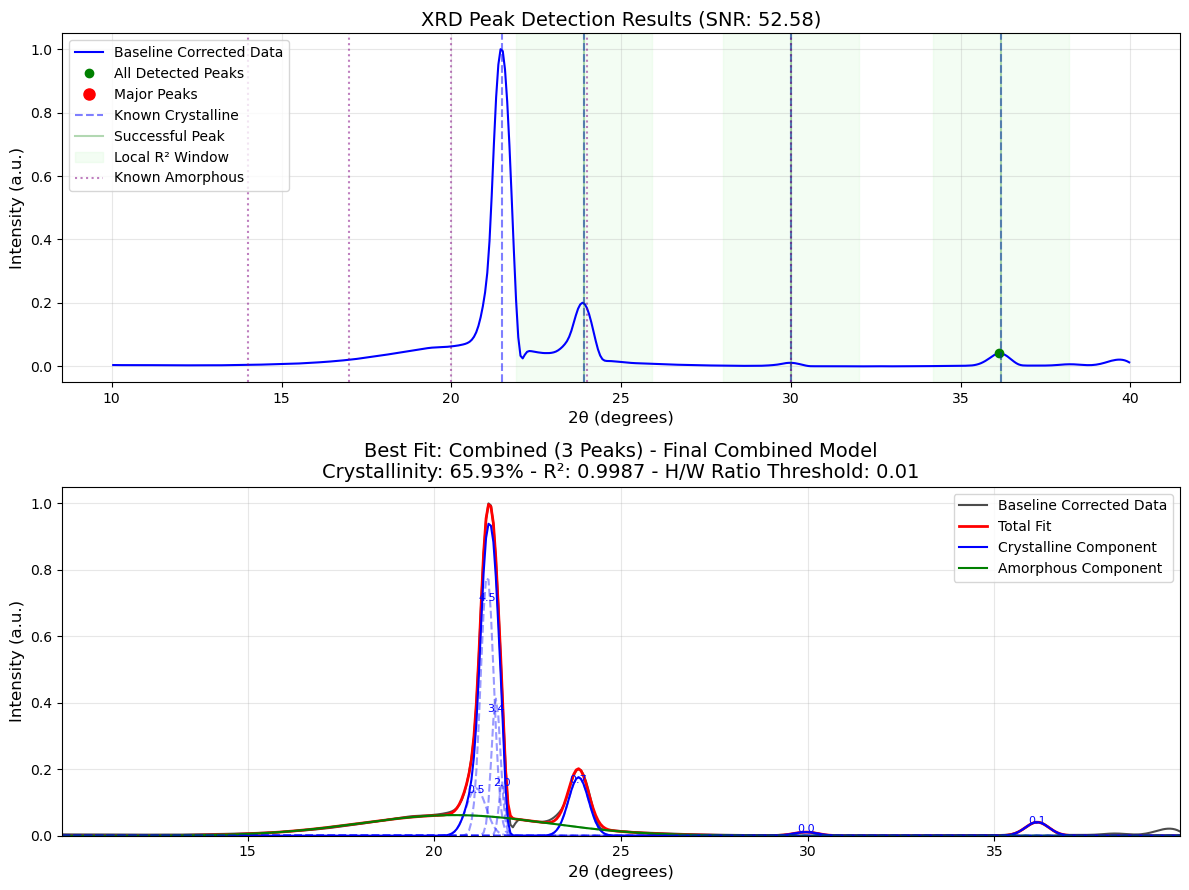

Processing file: HDPE_50C_1.csv
Low signal-to-noise ratio detected (1.79). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3039

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.5°...
Classifying peak at 21.38° as crystalline: height/width=3.97, width=0.24° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.12, width=0.28° (known position)
  Peak at 21.5°: DETECTED with good quality score (2.241) but overall R² = 0.9603 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.9°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 23.69° as crystalline: height/width=0.81, width=0.27° (known position)
Classifying peak at 36.06° as crystalline: height/width=0.11, width=0.31° (known position)
Classifying peak at 21.03° as crystalline: height/width=0.49, width=0.27° (known posi

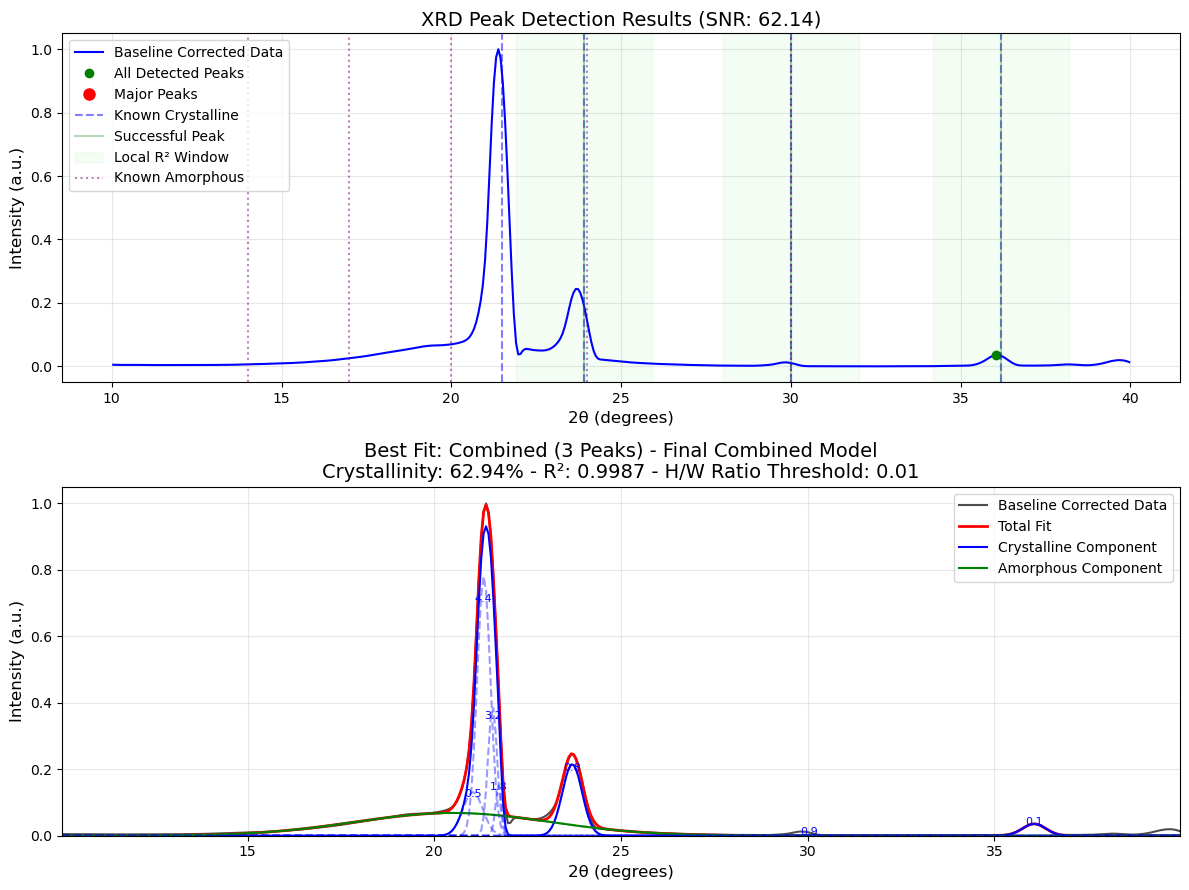

Processing file: HDPE_75C_1.csv
Low signal-to-noise ratio detected (1.86). Adjusting detection parameters.

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.3179

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 21.5°...
Classifying peak at 21.32° as crystalline: height/width=3.96, width=0.23° (known position)
Classifying peak at 36.05° as crystalline: height/width=0.12, width=0.28° (known position)
  Peak at 21.5°: DETECTED with good quality score (2.236) but overall R² = 0.9621 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 23.9°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 23.51° as crystalline: height/width=0.79, width=0.27° (known position)
Classifying peak at 36.05° as crystalline: height/width=0.11, width=0.31° (known position)
Classifying peak at 20.97° as crystalline: height/width=0.44, width=0.27° (known posi

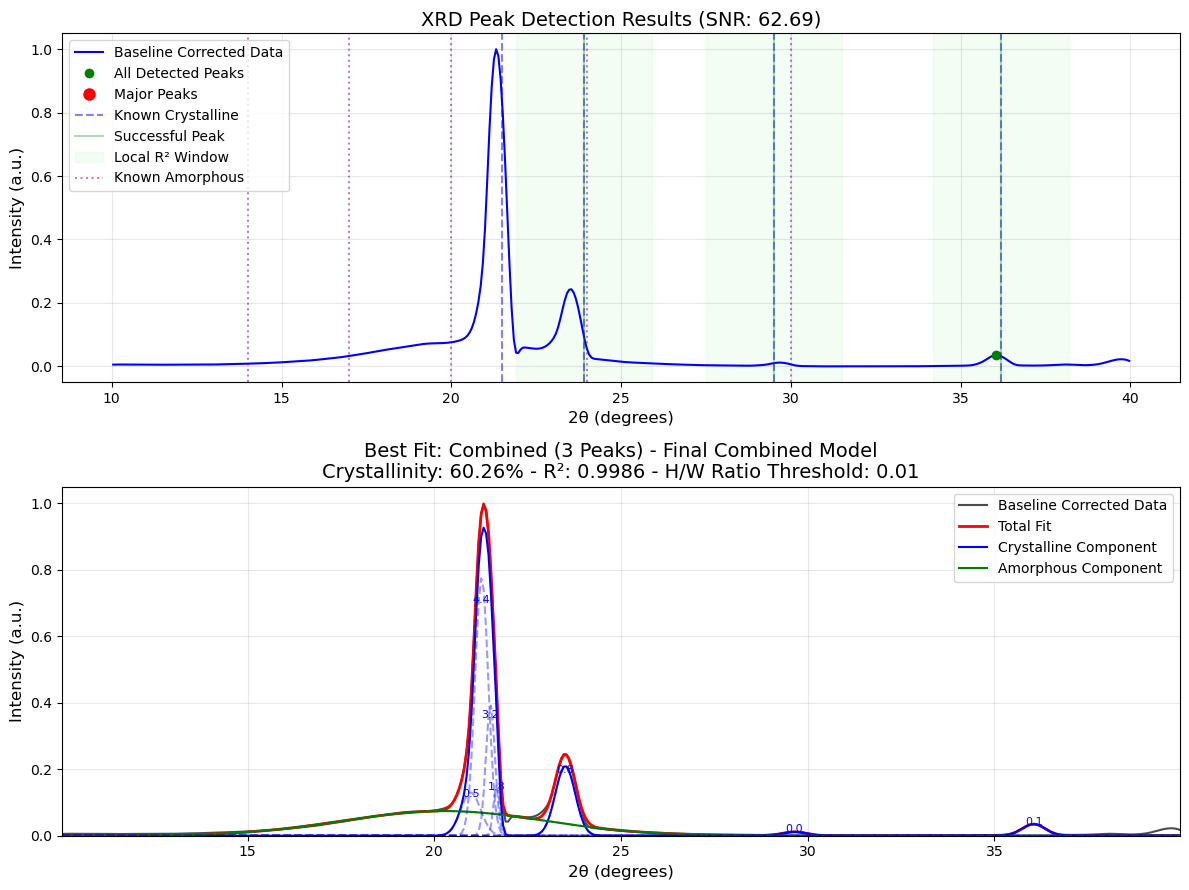

Processing file: PEEK500907_100C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: EXCELLENT - Amorphous-only fit with R² = 0.9932

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
  Peak at 18.7°: NOT DETECTED as crystalline
  Testing peak at 20.6°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 20.60° as crystalline: height/width=1.48, width=0.50° (known position)
  Peak at 20.6°: DETECTED but low quality score: -114.902
    - SNR: 0.62, Correlation: -0.620, RMSE improvement: -1.07889
  Testing peak at 22.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying p

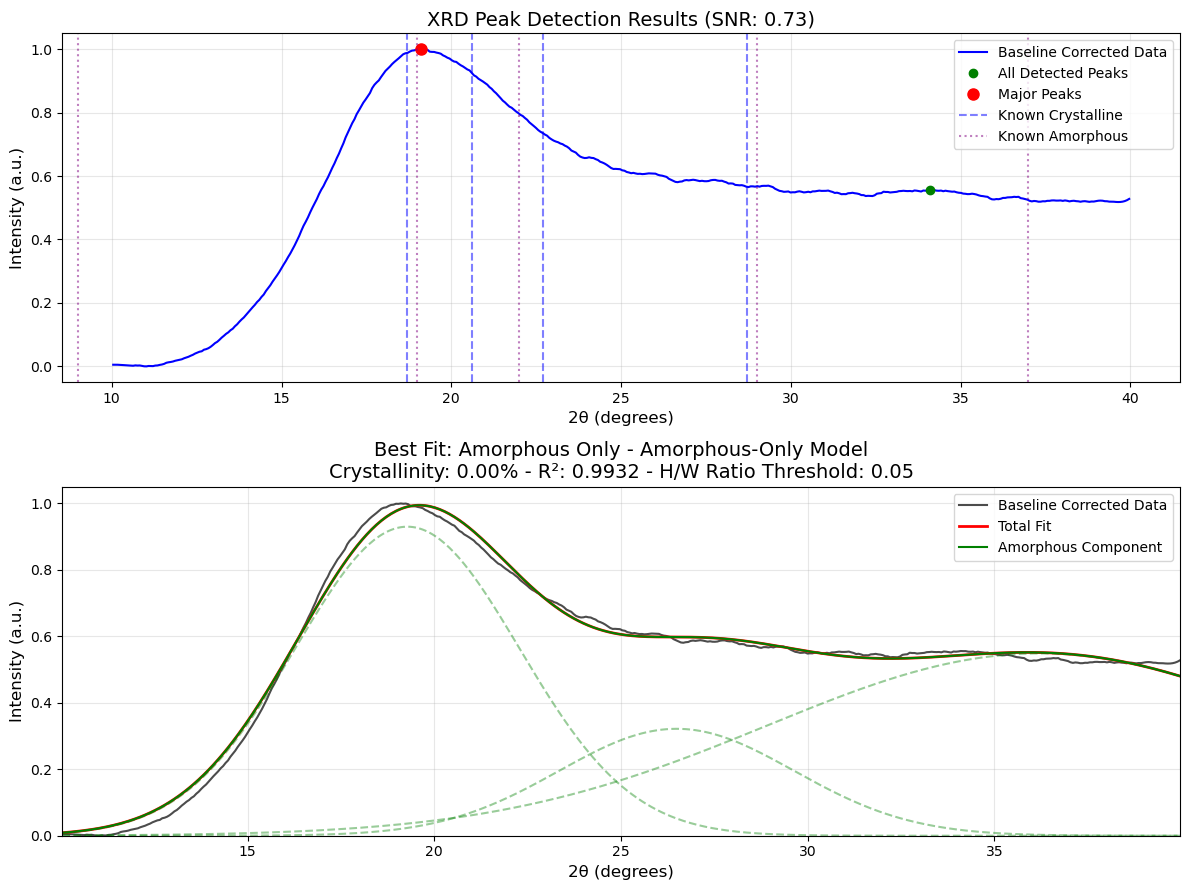

Processing file: PEEK500907_150C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: EXCELLENT - Amorphous-only fit with R² = 0.9973

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
  Peak at 18.7°: NOT DETECTED as crystalline
  Testing peak at 20.6°...
  Peak at 20.6°: NOT DETECTED as crystalline
  Testing peak at 22.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 22.70° as crystalline: height/width=0.98, width=0.50° (known position)
  Peak at 22.7°: DETECTED but low quality score: -60.516
    - SNR: 1.19, Correlation: 0.290, RMSE improvement: -0.98362
  Testing peak at 28.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found:

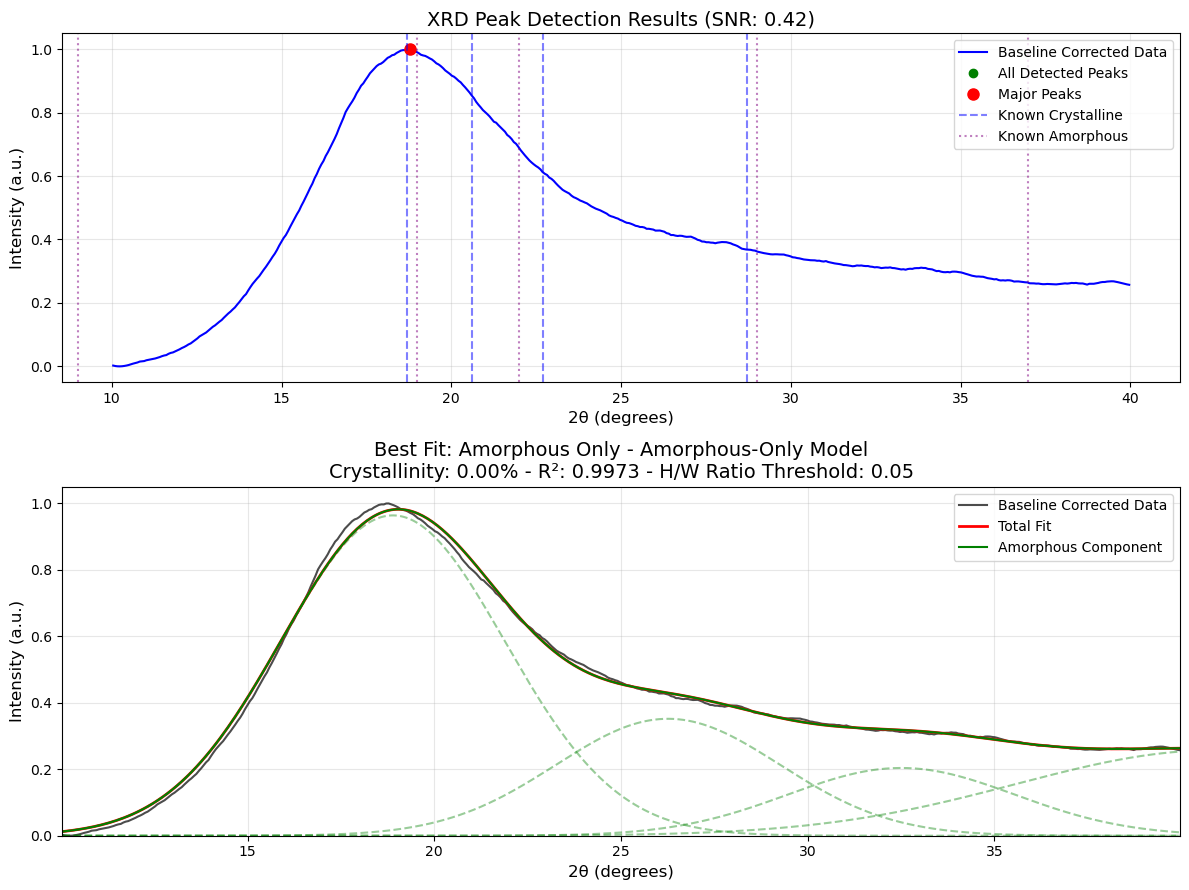

Processing file: PEEK500907_200C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: ACCEPTABLE - Amorphous-only fit with R² = 0.9203

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.8°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 18.28° as crystalline: height/width=0.99, width=0.48° (known position)
Classifying peak at 27.94° as crystalline: height/width=0.13, width=0.74° (known position)
Classifying peak at 19.96° as crystalline: height/width=0.30, width=0.55° (known position)
  Peak at 18.8°: DETECTED with good quality score (1.410) but overall R² = -42.9708 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 20.700000000000003°...
  Peak at 20.700000000000003°: NOT DETECTED as crystalline
  Testing peak at 22.9°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to fu

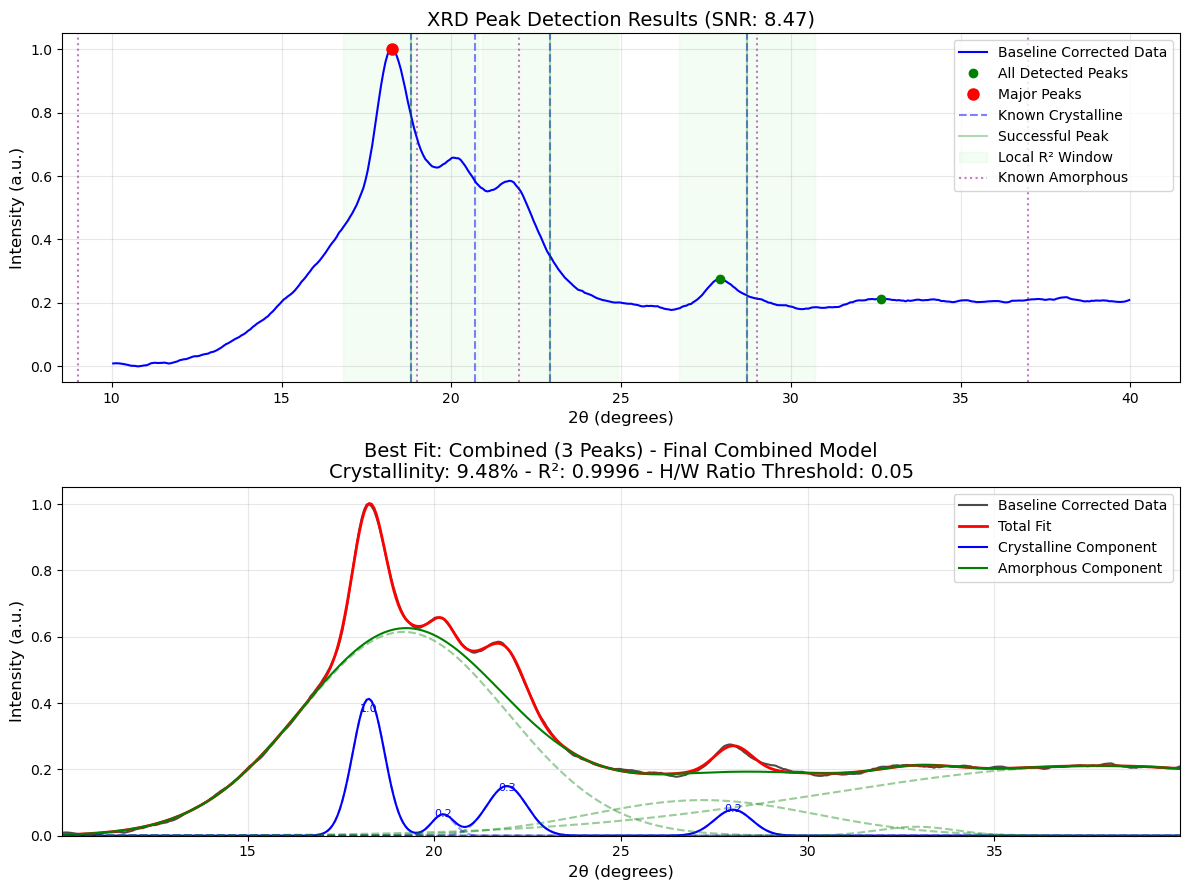

Processing file: PEEK500907_250C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.8906

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 18.21° as crystalline: height/width=1.10, width=0.41° (known position)
Classifying peak at 27.87° as crystalline: height/width=0.15, width=0.67° (known position)
Classifying peak at 23.31° as crystalline: height/width=90.52, width=0.00° (known position)
  Peak at 18.7°: SUCCESSFUL - Quality score: 2.200, SNR: 28.70, Correlation: 0.997, Overall R² = 0.9980
  Testing peak at 20.6°...
Classifying peak at 18.21° as crystalline: height/width=1.08, width=0.48° (known position)
Classifying peak at 27.86° as crystalline: height/width=0.16, width=0.55° (known position)
  Peak at 20.6°: SUCCESSFUL - Quality score: 1.073, SNR: 2.28, Correlation: 0.671, Overall R² 

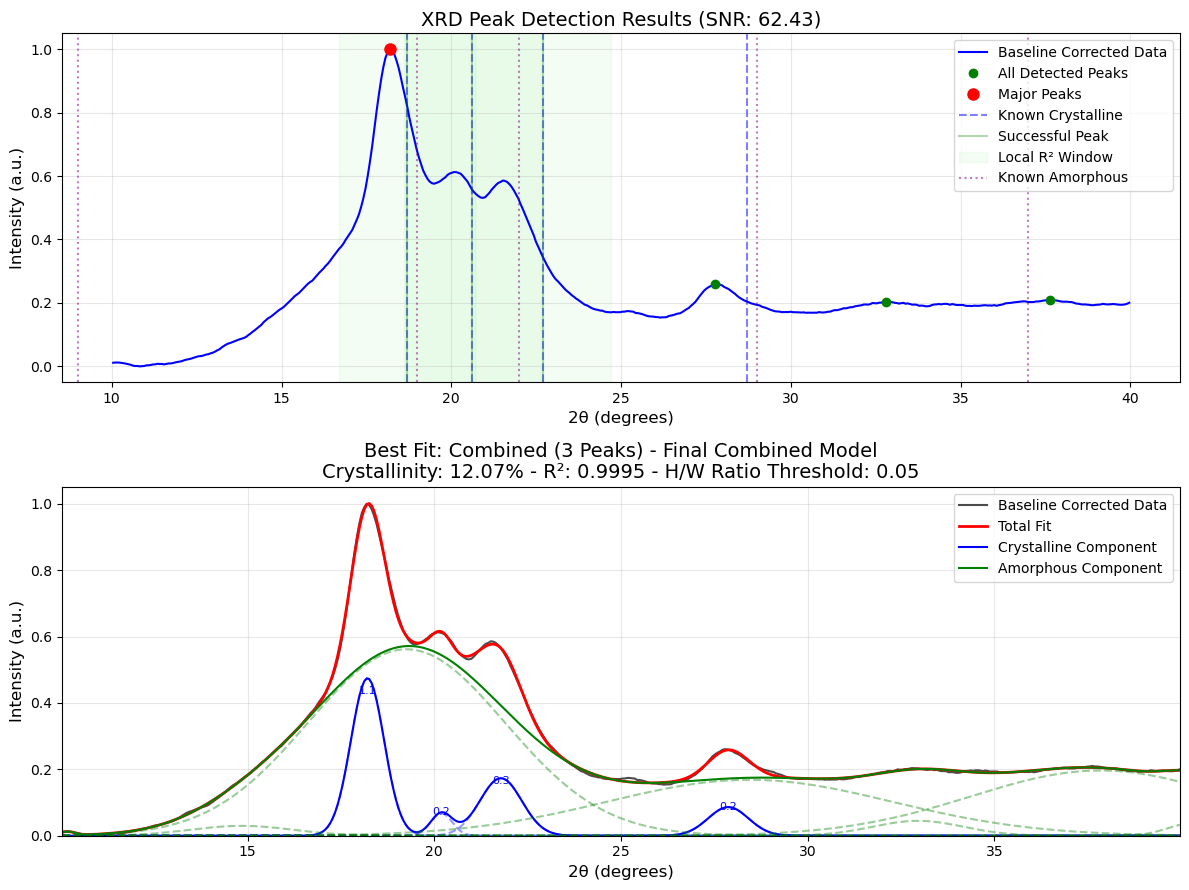

Processing file: PEEK500907_26C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: EXCELLENT - Amorphous-only fit with R² = 0.9952

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
  Peak at 18.7°: NOT DETECTED as crystalline
  Testing peak at 20.6°...
  Peak at 20.6°: NOT DETECTED as crystalline
  Testing peak at 22.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 22.70° as crystalline: height/width=1.24, width=0.50° (known position)
  Peak at 22.7°: DETECTED but low quality score: -100.860
    - SNR: 0.75, Correlation: 0.337, RMSE improvement: -1.03490
  Testing peak at 28.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found:

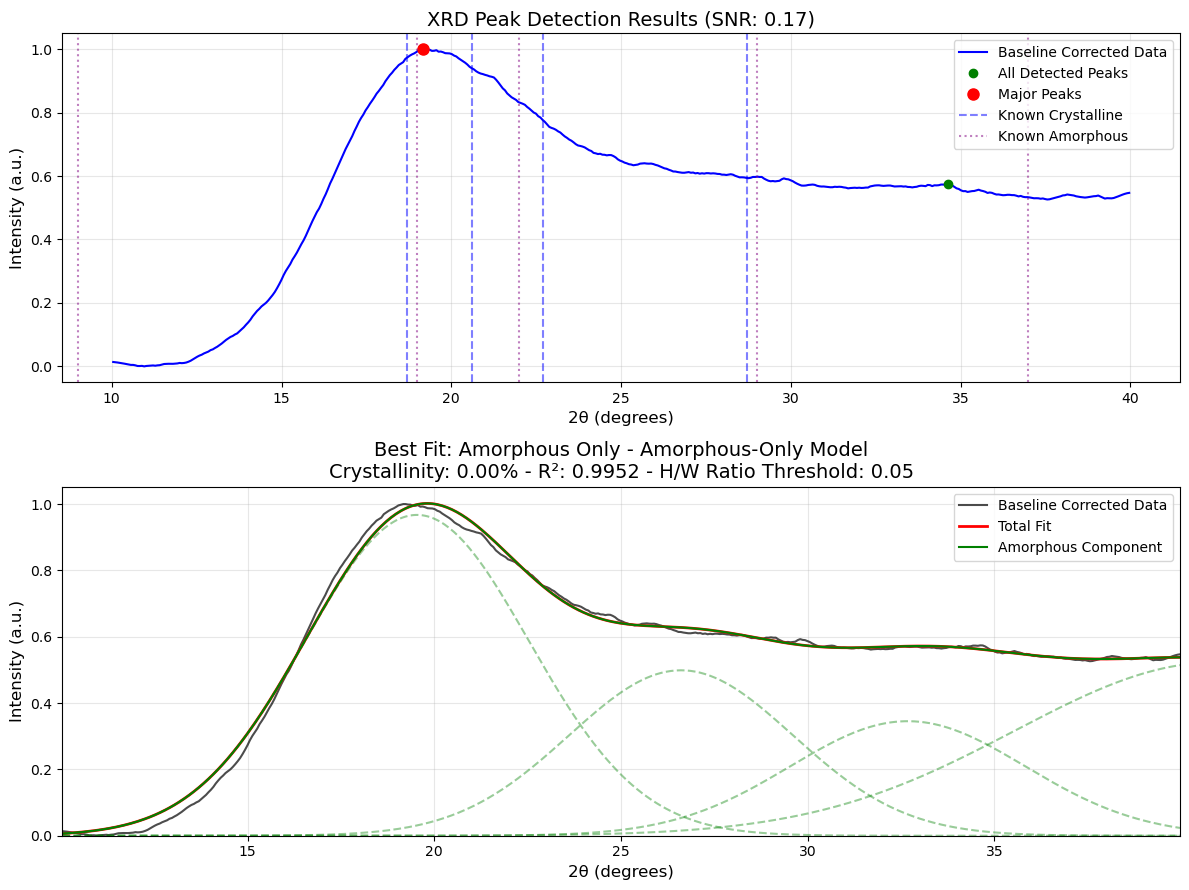

Processing file: PEEK500907_300C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.8708

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.2°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 18.15° as crystalline: height/width=1.21, width=0.44° (known position)
Classifying peak at 21.67° as crystalline: height/width=0.38, width=0.41° (known position)
Classifying peak at 27.73° as crystalline: height/width=0.19, width=0.61° (known position)
  Peak at 18.2°: DETECTED with good quality score (1.848) but overall R² = 0.5389 < 0.9900
    - Adding anyway due to high quality score
  Testing peak at 20.1°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 20.10° as crystalline: height/width=0.92, wid

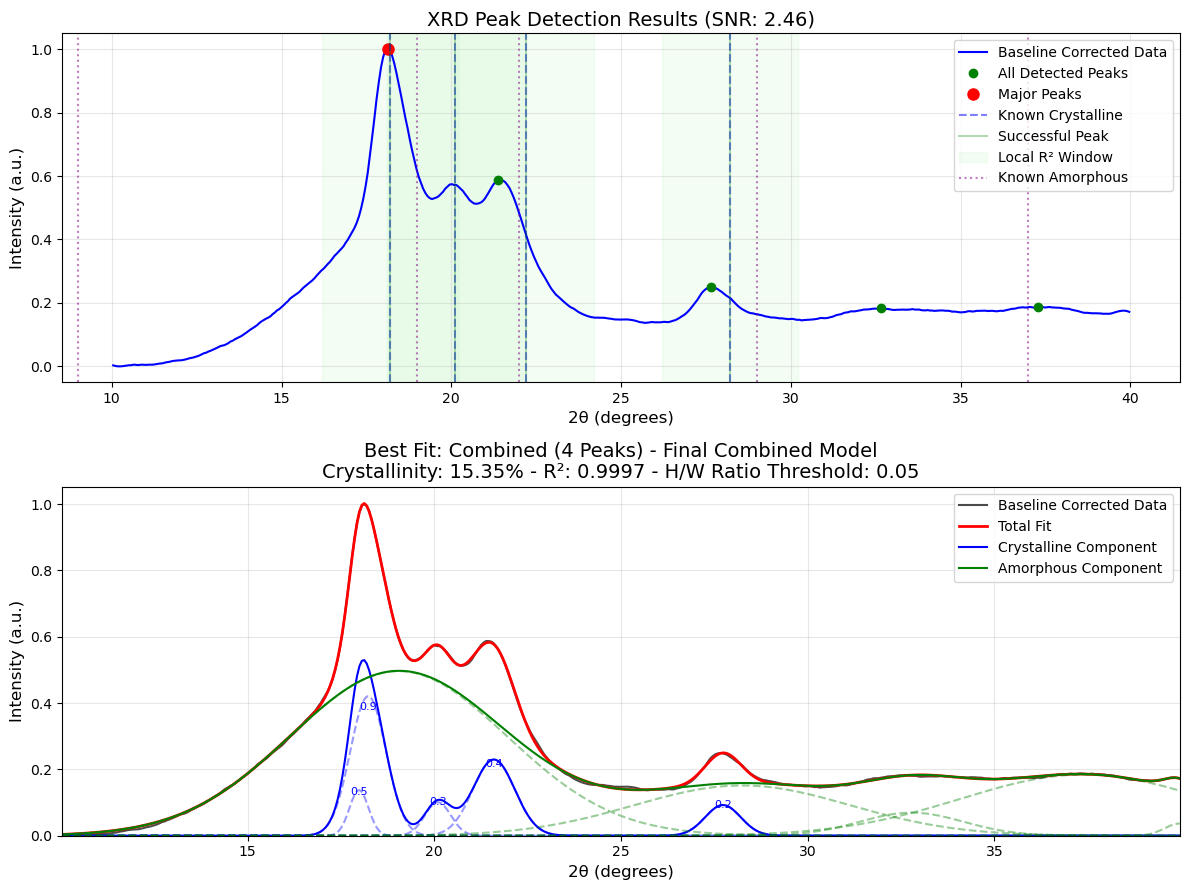

Processing file: PEEK500907_30C_after_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: INSUFFICIENT - Amorphous-only fit with R² = 0.8088

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
Classifying peak at 18.55° as crystalline: height/width=1.49, width=0.38° (known position)
Classifying peak at 22.53° as crystalline: height/width=0.66, width=0.42° (known position)
Classifying peak at 28.55° as crystalline: height/width=0.32, width=0.51° (known position)
  Peak at 18.7°: SUCCESSFUL - Quality score: 2.598, SNR: 37.95, Correlation: 0.998, Overall R² = 0.9946
  Testing peak at 20.6°...
Classifying peak at 20.54° as crystalline: height/width=0.42, width=0.36° (known position)
Classifying peak at 18.57° as crystalline: height/width=1.41, width=0.42° (known position)
Classifying peak at 22.49° as crystalline: height/width=0.64, width=0.45° (known position)

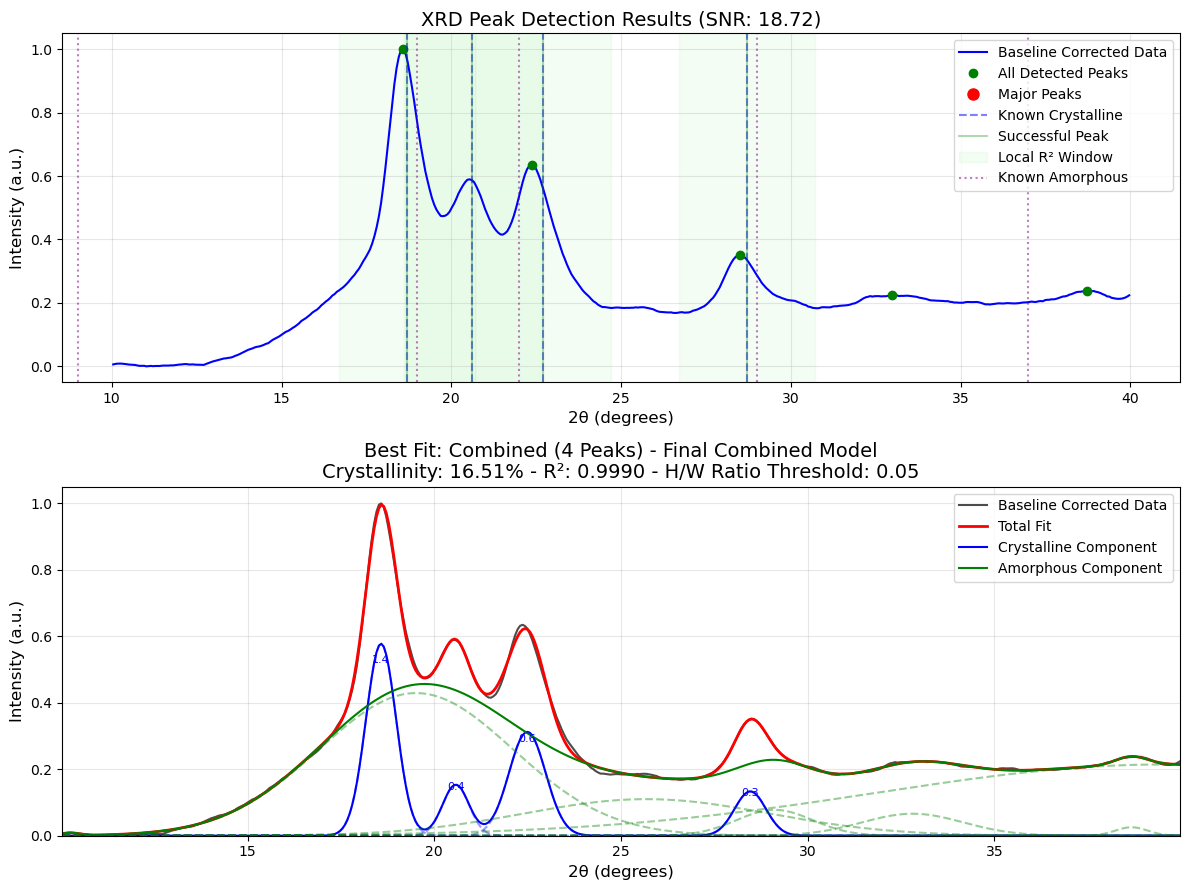

Processing file: PEEK500907_50C_1.csv

Phase 1: Performing amorphous-only fit...
Phase 1: EXCELLENT - Amorphous-only fit with R² = 0.9948

Phase 2A: Testing each crystalline peak individually...
  Testing peak at 18.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
  Peak at 18.7°: NOT DETECTED as crystalline
  Testing peak at 20.6°...
  Peak at 20.6°: NOT DETECTED as crystalline
  Testing peak at 22.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Success with unbounded fit
  Peak at 22.7°: NOT DETECTED as crystalline
  Testing peak at 28.7°...
ValueError (not x0): `x0` is infeasible.. Trying unbounded fit...
Unbounded fit also failed: Optimal parameters not found: Number of calls to function has reached maxfev = 25000.
Classifying peak at 28.70° as crystalline: height/width=0.96, width=0.50° (known position)
  Peak at 28.7°: DETECTED but low quality score: -491.524
    - SNR: 0.18, Correlation: -0.484, RMSE impro

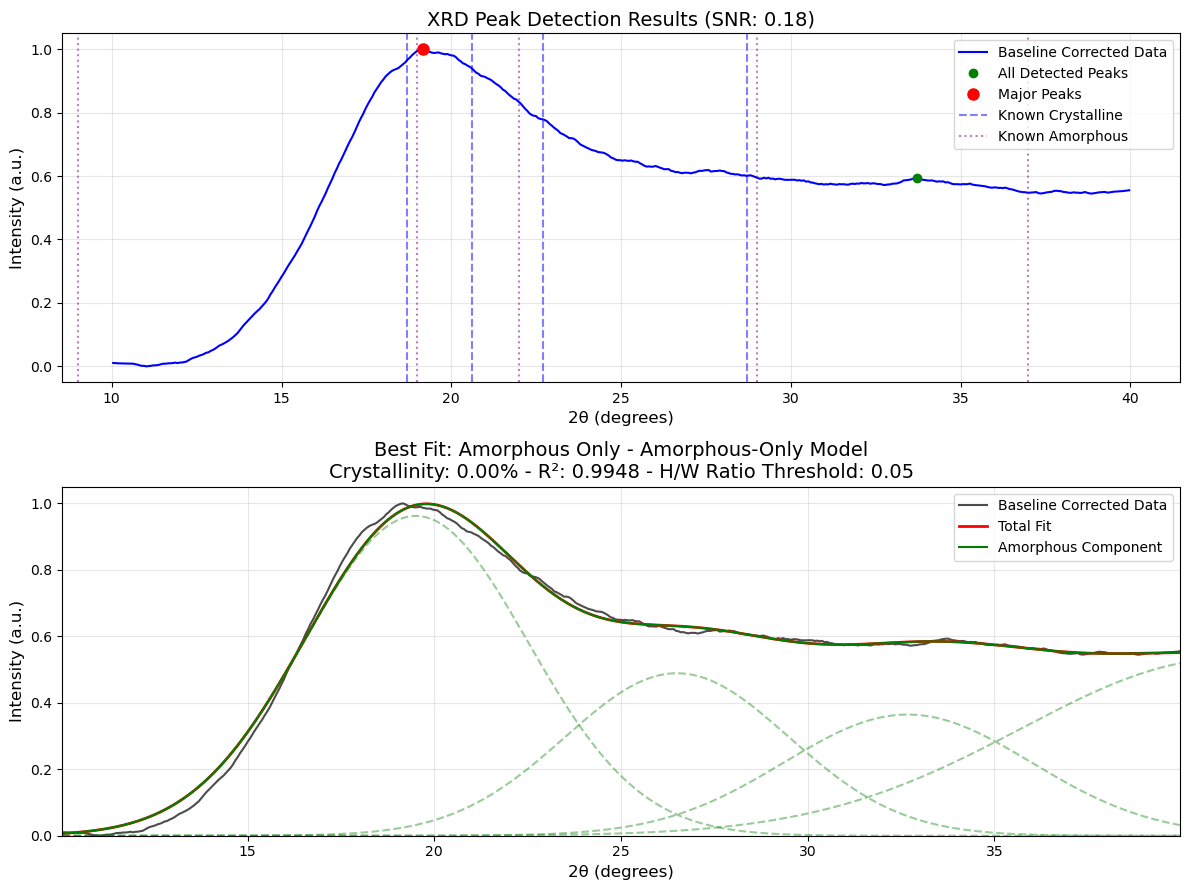

In [79]:
# Run all files
cryst_dict = {}
results_dict = {}
for file in all_files:
    print(f"Processing file: {file}")
    if 'HDPE' in file:
        polymer = 'HDPE'
    else:
        polymer = 'PEEK'
    data = df_dict[file]
    intensity = data['Intensity_norm'].values
    two_theta = data['2Theta'].values
    
    results = fit_xrd_spectrum_detailed(two_theta, intensity, 
                                        min_prominence=min_prominence_dict.get(polymer, 0.05),
                               known_crys_peaks=sample_crys_peaks_dict.get(file, None),
                               known_amorp_peaks=known_amorp_peaks_dict.get(polymer, None),
                               height_width_threshold=height_width_threshold_dict.get(polymer, 0.05),
                               min_r_squared=0.99, amorphous_r_squared=0.90,
                               visualise=True)
    
    cryst_dict[file] = results['crystallinity']
    results_dict[file] = results

## Export and plot

In [80]:
import pandas as pd
import os

"""
Export all XRD fitting results to a single Excel file with multiple tabs
"""
# Create results directory if it doesn't exist
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# Create Excel file path with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = os.path.join(results_dir, f"XRD_heated_results.xlsx")

# Create Excel writer object
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    
    # Lists to store overview data
    overview_data = []
    
    print("\nProcessing files for Excel export...")
    
    # Process each file
    for file in all_files:
        print(f"Processing {file}...")
        
        # Determine polymer type
        if 'HDPE' in file:
            polymer = 'HDPE'
        else:
            polymer = 'PEEK'
        
        # Get data
        data = df_dict[file]
        intensity = data['Intensity_norm'].values
        two_theta = data['2Theta'].values
        
        # Get XRD fitting
        results = results_dict[file]
        
        # Create tab name (remove file extension and sanitize for Excel)
        tab_name = os.path.splitext(file)[0]
        # Excel tab names have a 31 character limit and can't contain certain characters
        tab_name = tab_name.replace('[', '').replace(']', '').replace('*', '').replace('?', '').replace('/', '').replace('\\', '')
        if len(tab_name) > 31:
            tab_name = tab_name[:31]
        
        # Create DataFrame for this spectrum
        spectrum_df = pd.DataFrame({
            '2Theta_deg': two_theta,
            'Original_Intensity_normalized': results.get('baseline_corrected_intensity', intensity),
            'Total_Fit': results['total_fit'],
            'Crystalline_Fit': results['crystalline_fit'],
            'Amorphous_Fit': results['amorphous_fit'],
            'Residuals': results['residuals']
        })
        
        # Add spectrum to Excel file
        spectrum_df.to_excel(writer, sheet_name=tab_name, index=False)
        
        # Collect overview data
        overview_row = {
            'Filename': file,
            'Polymer_Type': polymer,
            'Crystallinity_percent': round(results['crystallinity'], 2),
            'R_squared': round(results['r_squared'], 4),
            'RMSE': round(results['rmse'], 6),
        }
        
        overview_data.append(overview_row)
    
    # Create overview DataFrame
    overview_df = pd.DataFrame(overview_data)
    
    # Add overview tab at the beginning
    overview_df.to_excel(writer, sheet_name='Overview', index=False)
    
    print(f"\nExcel file saved: {excel_filename}")   


Processing files for Excel export...
Processing HDPE_100C_1.csv...
Processing HDPE_110C_1.csv...
Processing HDPE_120C_1.csv...
Processing HDPE_29C_1.csv...
Processing HDPE_31C_after_1.csv...
Processing HDPE_50C_1.csv...
Processing HDPE_75C_1.csv...
Processing PEEK500907_100C_1.csv...
Processing PEEK500907_150C_1.csv...
Processing PEEK500907_200C_1.csv...
Processing PEEK500907_250C_1.csv...
Processing PEEK500907_26C_1.csv...
Processing PEEK500907_300C_1.csv...
Processing PEEK500907_30C_after_1.csv...
Processing PEEK500907_50C_1.csv...

Excel file saved: ../results\XRD_heated_results.xlsx


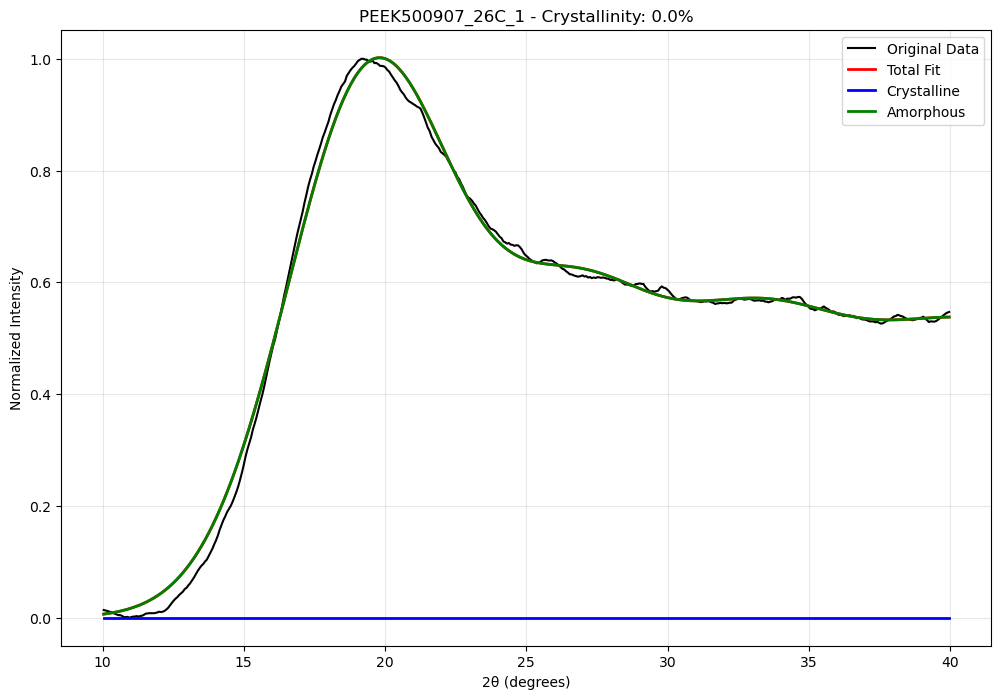

In [ ]:
def plot_xrd_from_excel(excel_file_path, sample_name):
    """
    Read Excel file and plot XRD analysis results for a specific sample.
    
    Parameters:
    -----------
    excel_file_path : str
        Path to the Excel file
    sample_name : str
        Sample name without file extension (e.g., 'PEEK500907_26C_1')
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    # Load overview to find sample info
    overview_df = pd.read_excel(excel_file_path, sheet_name='Overview')
    sample_row = overview_df[overview_df['Filename'].str.contains(sample_name, case=False, na=False)]
    
    if sample_row.empty:
        print(f"Sample '{sample_name}' not found")
        return
    
    sample_info = sample_row.iloc[0]
    
    # Create tab name
    tab_name = os.path.splitext(sample_info['Filename'])[0]
    if len(tab_name) > 31:
        tab_name = tab_name[:31]
    
    # Load spectrum data
    spectrum_df = pd.read_excel(excel_file_path, sheet_name=tab_name)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Original_Intensity_normalized'], 
             'k-', linewidth=1.5, label='Original Data')
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Total_Fit'], 
             'r-', linewidth=2, label='Total Fit')
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Crystalline_Fit'], 
             'b-', linewidth=2, label='Crystalline')
    plt.plot(spectrum_df['2Theta_deg'], spectrum_df['Amorphous_Fit'], 
             'g-', linewidth=2, label='Amorphous')
    
    plt.xlabel('2θ (degrees)')
    plt.ylabel('Normalized Intensity')
    plt.title(f"{sample_name} - Crystallinity: {sample_info['Crystallinity_percent']:.1f}%")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage
plot_xrd_from_excel('../results/XRD_heated_results.xlsx', 'PEEK500907_26C_1')

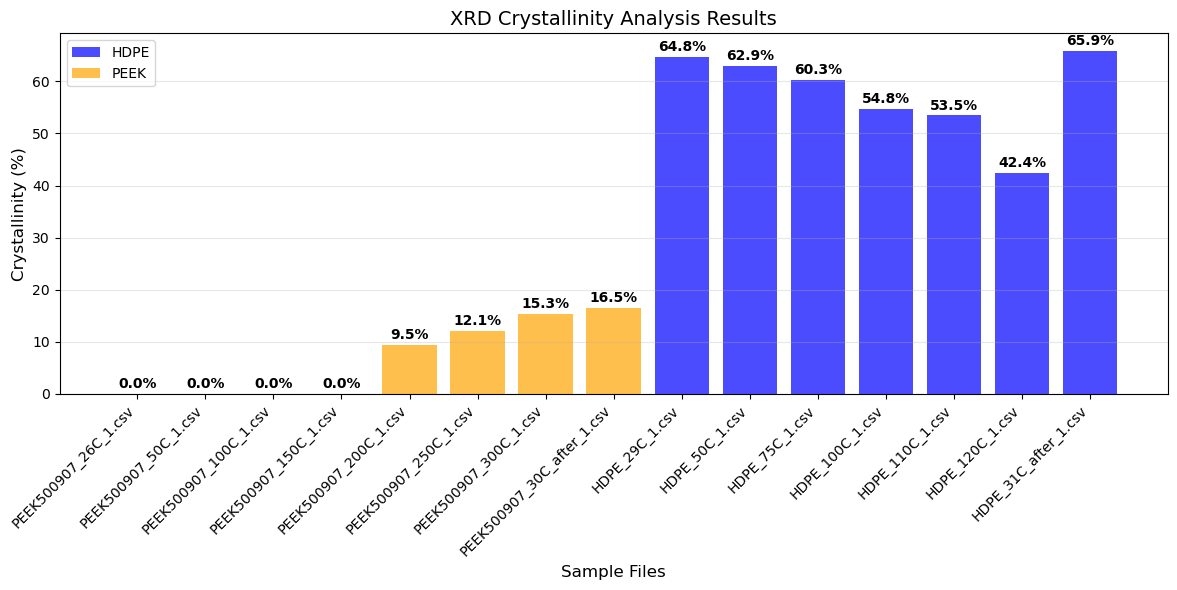

In [ ]:
def plot_crystallinity_from_excel(excel_file_path):
    # Plot comparison plot
    from matplotlib.patches import Patch
    
    # Define the desired order
    desired_order = [
        'PEEK500907_26C_1.csv',
        'PEEK500907_50C_1.csv',
        'PEEK500907_100C_1.csv',
        'PEEK500907_150C_1.csv',
        'PEEK500907_200C_1.csv',
        'PEEK500907_250C_1.csv',
        'PEEK500907_300C_1.csv',
        'PEEK500907_30C_after_1.csv',
        'HDPE_29C_1.csv',
        'HDPE_50C_1.csv',
        'HDPE_75C_1.csv',
        'HDPE_100C_1.csv',
        'HDPE_110C_1.csv',
        'HDPE_120C_1.csv',
        'HDPE_31C_after_1.csv'
    ]
    
    # Store results
    overview_df = pd.read_excel(excel_file_path, sheet_name='Overview')
    cryst_dict = dict(zip(overview_df['Filename'], overview_df['Crystallinity_percent']))
    
    ordered_files = []
    ordered_crystallinity = []
    for file in desired_order:
        if file in cryst_dict:
            ordered_files.append(file)
            ordered_crystallinity.append(cryst_dict[file])

    # Create color mapping for different polymers
    colors = ['blue' if 'HDPE' in file else 'orange' for file in ordered_files]

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(ordered_files, ordered_crystallinity, color=colors, alpha=0.7)

    # Add value labels on top of bars
    for bar, value in zip(bars, ordered_crystallinity):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Sample Files', fontsize=12)
    plt.ylabel('Crystallinity (%)', fontsize=12)
    plt.title('XRD Crystallinity Analysis Results', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add legend
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='HDPE'),
                    Patch(facecolor='orange', alpha=0.7, label='PEEK')]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.show()

# Usage
plot_crystallinity_from_excel('../results/XRD_heated_results.xlsx')